<h3>輸入原影像，經過壓縮轉換，再由轉換壓縮碼，還原成類原圖</h3>

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [2]:
from glob import glob
import numpy

In [3]:
import cv2

In [4]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator

In [5]:
import keras
from keras import layers
from keras.models import Model
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [6]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from pylab import rcParams
from matplotlib import cm

<h3>環境設置</h3>

In [7]:
image_path = 'images/objects/train'
max_dim = (256, 256, 3)
enhanced_flag = False

kernel = numpy.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]])

alpha = 0.6 # Contrast control (1.0-3.0)
beta = 2 # Brightness control (0-100)

In [8]:
def read_image_file(my_image_file, enhanced=False):
    global max_dim, kernel, alpha, beta
    
    _fish_image = cv2.imread(my_image_file, cv2.COLOR_BGR2RGB)
    
    if enhanced:
        _fish_image = cv2.filter2D(_fish_image, -1, kernel)
        _fish_image = cv2.convertScaleAbs(_fish_image.copy(), alpha=alpha, beta=beta)

    _fish_image = cv2.resize(_fish_image.copy(), max_dim[:2])
    
    return _fish_image

In [9]:
def show_image(my_image):
    global max_dim
    
    _my_image = numpy.reshape(my_image, max_dim)
    
    fig, ax = plt.subplots(dpi=120)
    
    ax.imshow(my_image)
    ax.axis('off')
    
    plt.show()

<h3>載入魚影像檔</h3>

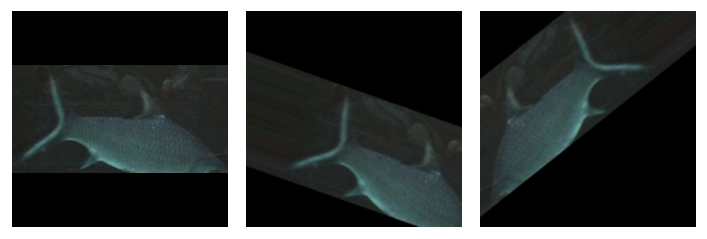

In [10]:
datagen = ImageDataGenerator(rotation_range=45,
                             width_shift_range=[0.1, 0.2],
                             height_shift_range=[0.1, 0.2],
                             horizontal_flip=True)

_fish_image = read_image_file('%s/F000079-00001.jpg' % image_path, enhanced_flag)

fig, ax = plt.subplots(dpi=120, ncols=3)

ax[0].imshow(_fish_image)
ax[0].axis('off')

_fish_img_data = img_to_array(_fish_image)    
_fish_img_data = numpy.expand_dims(_fish_img_data, 0)

it = datagen.flow(_fish_img_data, batch_size=1)

for i in range(1, 3):
    _batch = it.next()
    _generated_image = _batch[0].astype('uint8')
            
    ax[i].imshow(_generated_image, cmap='gray', interpolation='bicubic')
    ax[i].axis('off')
    
plt.tight_layout()
plt.show()

In [11]:
def load_data(image_path, train_ratio=0.8, enhanced=False):
    global max_dim

    datagen = ImageDataGenerator(rotation_range=45,
                                 width_shift_range=[0.1, 0.2],
                                 height_shift_range=[0.1, 0.2],
                                 horizontal_flip=True
    )
    
    image_files = glob('%s/F*.jpg' % image_path)

    my_images = []

    for image_file in image_files:
        _image_file = image_file.replace('\\', '/')
        
        _fish_image = read_image_file(_image_file, enhanced)
        
        my_images.append(numpy.reshape(_fish_image, max_dim))

        _fish_img_data = img_to_array(_fish_image)    
        _fish_img_data = numpy.expand_dims(_fish_img_data, 0)
        
        it = datagen.flow(_fish_img_data, batch_size=1)

        for i in range(10):
            _batch = it.next()
            _generated_image = _batch[0].astype('uint8')
            
            my_images.append(numpy.reshape(_generated_image, max_dim))

    my_images = numpy.array(my_images)
    numpy.random.shuffle(my_images)
    
    pos = int(my_images.shape[0] * train_ratio)
    return my_images[:pos], my_images[pos:]

In [12]:
x_train, x_test = load_data(image_path, 0.8, enhanced_flag)

In [13]:
x_train.shape, x_test.shape

((4488, 256, 256, 3), (1122, 256, 256, 3))

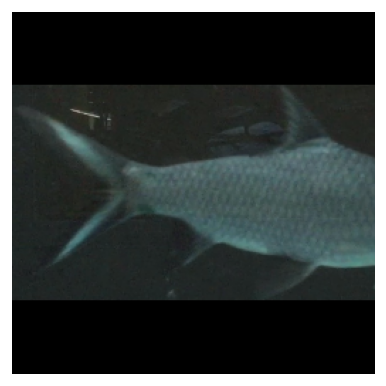

In [14]:
show_image(x_train[numpy.random.randint(len(x_train))])

<h3>將 0 ~ 255 值域，轉換為: 0 ~ 1</h3>

In [15]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

<h3>參數設置</h3>
<p>$$壓縮率: \frac {{256}*{256}={65536}}{64} = 1024$$</p>

<h3>建立模型</h3>

In [16]:
input_img = keras.Input(shape=max_dim, name='input')

In [17]:
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='Conv2D_64')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same', name='MaxPooling2D_64')(x)

In [18]:
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same', name='Conv2D_32')(x)
x = layers.MaxPooling2D((2, 2), padding='same', name='MaxPooling2D_32')(x)

In [19]:
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same', name='Conv2D_16')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same', name='latent')(x)

In [20]:
x = layers.Conv2DTranspose(16, (3, 3), activation='relu', padding='same', name='Conv2DT_16')(encoded)
x = layers.UpSampling2D((2, 2), name='UpSampling2D_16')(x)

In [21]:
x = layers.Conv2DTranspose(32, (3, 3), activation='relu', padding='same', name='Conv2DT_32')(x)
x = layers.UpSampling2D((2, 2), name='UpSampling2D_32')(x)

In [22]:
x = layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same', name='Conv2DT_64')(x)
x = layers.UpSampling2D((2, 2), name='UpSampling2D_64')(x)

In [23]:
decoded = layers.Conv2D(max_dim[-1], (3, 3), padding='same', name='output')(x)

In [24]:
autoencoder = keras.Model(input_img, decoded)

In [25]:
autoencoder.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 256, 256, 3)]     0         
_________________________________________________________________
Conv2D_64 (Conv2D)           (None, 256, 256, 64)      1792      
_________________________________________________________________
MaxPooling2D_64 (MaxPooling2 (None, 128, 128, 64)      0         
_________________________________________________________________
Conv2D_32 (Conv2D)           (None, 128, 128, 32)      18464     
_________________________________________________________________
MaxPooling2D_32 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
Conv2D_16 (Conv2D)           (None, 64, 64, 16)        4624      
_________________________________________________________________
latent (MaxPooling2D)        (None, 32, 32, 16)       

In [26]:
autoencoder.compile(optimizer='adam', loss='mse')  # binary_crossentropy

<h3>訓練模型</h3>

In [27]:
checkpointer = ModelCheckpoint(
    filepath='CNN-C-1-64-32-16.hdf5', 
    monitor="val_loss", verbose=1, 
    save_best_only=True, mode='auto'
)

earlyStop = EarlyStopping(monitor='val_loss', patience=50)

In [28]:
num_of_epoch = 512
num_of_batch_size = 8

In [29]:
score = autoencoder.fit(x_train, x_train,
                        epochs=num_of_epoch,
                        batch_size=num_of_batch_size,
                        shuffle=True,
                        validation_data=(x_test, x_test),
                        callbacks=[checkpointer, earlyStop]
                       )

Epoch 1/512
559/561 [============================>.] - ETA: 0s - loss: 6.1950e-04
Epoch 00001: val_loss improved from inf to 0.00021, saving model to CNN-C-1-64-32-16.hdf5
561/561 [==============================] - 14s 24ms/step - loss: 6.1812e-04 - val_loss: 2.1420e-04
Epoch 2/512
559/561 [============================>.] - ETA: 0s - loss: 2.0115e-04
Epoch 00002: val_loss improved from 0.00021 to 0.00017, saving model to CNN-C-1-64-32-16.hdf5
561/561 [==============================] - 13s 23ms/step - loss: 2.0099e-04 - val_loss: 1.7359e-04
Epoch 3/512
559/561 [============================>.] - ETA: 0s - loss: 1.7063e-04
Epoch 00003: val_loss improved from 0.00017 to 0.00015, saving model to CNN-C-1-64-32-16.hdf5
561/561 [==============================] - 13s 23ms/step - loss: 1.7063e-04 - val_loss: 1.5456e-04
Epoch 4/512
559/561 [============================>.] - ETA: 0s - loss: 1.6156e-04
Epoch 00004: val_loss improved from 0.00015 to 0.00014, saving model to CNN-C-1-64-32-16.hdf5
561

559/561 [============================>.] - ETA: 0s - loss: 8.7931e-05
Epoch 00032: val_loss improved from 0.00009 to 0.00009, saving model to CNN-C-1-64-32-16.hdf5
561/561 [==============================] - 13s 23ms/step - loss: 8.7929e-05 - val_loss: 8.5698e-05
Epoch 33/512
559/561 [============================>.] - ETA: 0s - loss: 8.7158e-05
Epoch 00033: val_loss improved from 0.00009 to 0.00008, saving model to CNN-C-1-64-32-16.hdf5
561/561 [==============================] - 13s 23ms/step - loss: 8.7139e-05 - val_loss: 8.3137e-05
Epoch 34/512
559/561 [============================>.] - ETA: 0s - loss: 8.9047e-05
Epoch 00034: val_loss improved from 0.00008 to 0.00008, saving model to CNN-C-1-64-32-16.hdf5
561/561 [==============================] - 13s 23ms/step - loss: 8.9059e-05 - val_loss: 8.1385e-05
Epoch 35/512
559/561 [============================>.] - ETA: 0s - loss: 8.2890e-05
Epoch 00035: val_loss did not improve from 0.00008
561/561 [==============================] - 13s 23ms

Epoch 65/512
559/561 [============================>.] - ETA: 0s - loss: 7.4680e-05
Epoch 00065: val_loss did not improve from 0.00007
561/561 [==============================] - 13s 23ms/step - loss: 7.4694e-05 - val_loss: 8.3916e-05
Epoch 66/512
559/561 [============================>.] - ETA: 0s - loss: 7.3861e-05
Epoch 00066: val_loss improved from 0.00007 to 0.00007, saving model to CNN-C-1-64-32-16.hdf5
561/561 [==============================] - 13s 23ms/step - loss: 7.3835e-05 - val_loss: 7.1210e-05
Epoch 67/512
559/561 [============================>.] - ETA: 0s - loss: 7.5162e-05
Epoch 00067: val_loss did not improve from 0.00007
561/561 [==============================] - 13s 23ms/step - loss: 7.5129e-05 - val_loss: 7.3559e-05
Epoch 68/512
561/561 [==============================] - ETA: 0s - loss: 7.2522e-05
Epoch 00068: val_loss did not improve from 0.00007
561/561 [==============================] - 13s 23ms/step - loss: 7.2522e-05 - val_loss: 7.4297e-05
Epoch 69/512
561/561 [===

Epoch 99/512
559/561 [============================>.] - ETA: 0s - loss: 6.7518e-05
Epoch 00099: val_loss did not improve from 0.00007
561/561 [==============================] - 13s 23ms/step - loss: 6.7512e-05 - val_loss: 6.7656e-05
Epoch 100/512
561/561 [==============================] - ETA: 0s - loss: 6.9477e-05
Epoch 00100: val_loss did not improve from 0.00007
561/561 [==============================] - 13s 23ms/step - loss: 6.9477e-05 - val_loss: 6.7202e-05
Epoch 101/512
561/561 [==============================] - ETA: 0s - loss: 6.7125e-05
Epoch 00101: val_loss did not improve from 0.00007
561/561 [==============================] - 13s 23ms/step - loss: 6.7125e-05 - val_loss: 6.6829e-05
Epoch 102/512
561/561 [==============================] - ETA: 0s - loss: 7.0841e-05
Epoch 00102: val_loss did not improve from 0.00007
561/561 [==============================] - 13s 23ms/step - loss: 7.0841e-05 - val_loss: 7.4599e-05
Epoch 103/512
561/561 [==============================] - ETA: 0s 

Epoch 133/512
559/561 [============================>.] - ETA: 0s - loss: 6.5864e-05
Epoch 00133: val_loss did not improve from 0.00006
561/561 [==============================] - 13s 23ms/step - loss: 6.5861e-05 - val_loss: 6.4250e-05
Epoch 134/512
559/561 [============================>.] - ETA: 0s - loss: 6.5151e-05
Epoch 00134: val_loss did not improve from 0.00006
561/561 [==============================] - 13s 23ms/step - loss: 6.5130e-05 - val_loss: 6.6074e-05
Epoch 135/512
561/561 [==============================] - ETA: 0s - loss: 7.7914e-05
Epoch 00135: val_loss did not improve from 0.00006
561/561 [==============================] - 13s 23ms/step - loss: 7.7914e-05 - val_loss: 9.0699e-05
Epoch 136/512
559/561 [============================>.] - ETA: 0s - loss: 6.6770e-05
Epoch 00136: val_loss did not improve from 0.00006
561/561 [==============================] - 13s 23ms/step - loss: 6.6724e-05 - val_loss: 6.5342e-05
Epoch 137/512
559/561 [============================>.] - ETA: 0s

559/561 [============================>.] - ETA: 0s - loss: 6.6205e-05
Epoch 00167: val_loss did not improve from 0.00006
561/561 [==============================] - 13s 23ms/step - loss: 6.6242e-05 - val_loss: 8.6258e-05
Epoch 168/512
559/561 [============================>.] - ETA: 0s - loss: 6.3993e-05
Epoch 00168: val_loss did not improve from 0.00006
561/561 [==============================] - 13s 23ms/step - loss: 6.3994e-05 - val_loss: 6.2944e-05
Epoch 169/512
559/561 [============================>.] - ETA: 0s - loss: 6.7228e-05
Epoch 00169: val_loss did not improve from 0.00006
561/561 [==============================] - 13s 23ms/step - loss: 6.7217e-05 - val_loss: 6.3356e-05
Epoch 170/512
559/561 [============================>.] - ETA: 0s - loss: 6.4485e-05
Epoch 00170: val_loss did not improve from 0.00006
561/561 [==============================] - 13s 23ms/step - loss: 6.4496e-05 - val_loss: 6.3080e-05
Epoch 171/512
559/561 [============================>.] - ETA: 0s - loss: 6.456

559/561 [============================>.] - ETA: 0s - loss: 6.3702e-05
Epoch 00201: val_loss did not improve from 0.00006
561/561 [==============================] - 13s 23ms/step - loss: 6.3872e-05 - val_loss: 1.0435e-04
Epoch 202/512
561/561 [==============================] - ETA: 0s - loss: 6.4158e-05
Epoch 00202: val_loss did not improve from 0.00006
561/561 [==============================] - 13s 23ms/step - loss: 6.4158e-05 - val_loss: 6.7859e-05
Epoch 203/512
561/561 [==============================] - ETA: 0s - loss: 6.5007e-05
Epoch 00203: val_loss did not improve from 0.00006
561/561 [==============================] - 13s 23ms/step - loss: 6.5007e-05 - val_loss: 6.6748e-05
Epoch 204/512
559/561 [============================>.] - ETA: 0s - loss: 6.4808e-05
Epoch 00204: val_loss did not improve from 0.00006
561/561 [==============================] - 13s 23ms/step - loss: 6.4789e-05 - val_loss: 6.1288e-05
Epoch 205/512
561/561 [==============================] - ETA: 0s - loss: 6.260

559/561 [============================>.] - ETA: 0s - loss: 6.6345e-05
Epoch 00235: val_loss did not improve from 0.00006
561/561 [==============================] - 13s 23ms/step - loss: 6.6311e-05 - val_loss: 6.1036e-05
Epoch 236/512
559/561 [============================>.] - ETA: 0s - loss: 6.1605e-05
Epoch 00236: val_loss did not improve from 0.00006
561/561 [==============================] - 13s 23ms/step - loss: 6.1613e-05 - val_loss: 6.3922e-05
Epoch 237/512
559/561 [============================>.] - ETA: 0s - loss: 6.1959e-05
Epoch 00237: val_loss did not improve from 0.00006
561/561 [==============================] - 13s 23ms/step - loss: 6.1953e-05 - val_loss: 6.3244e-05
Epoch 238/512
559/561 [============================>.] - ETA: 0s - loss: 6.1812e-05
Epoch 00238: val_loss did not improve from 0.00006
561/561 [==============================] - 13s 23ms/step - loss: 6.1944e-05 - val_loss: 9.2806e-05
Epoch 239/512
561/561 [==============================] - ETA: 0s - loss: 6.314

559/561 [============================>.] - ETA: 0s - loss: 6.1529e-05
Epoch 00269: val_loss did not improve from 0.00006
561/561 [==============================] - 13s 23ms/step - loss: 6.1504e-05 - val_loss: 6.0166e-05
Epoch 270/512
561/561 [==============================] - ETA: 0s - loss: 6.2119e-05
Epoch 00270: val_loss did not improve from 0.00006
561/561 [==============================] - 13s 23ms/step - loss: 6.2119e-05 - val_loss: 6.0399e-05
Epoch 271/512
561/561 [==============================] - ETA: 0s - loss: 6.1842e-05
Epoch 00271: val_loss did not improve from 0.00006
561/561 [==============================] - 13s 23ms/step - loss: 6.1842e-05 - val_loss: 6.9370e-05
Epoch 272/512
559/561 [============================>.] - ETA: 0s - loss: 6.0373e-05
Epoch 00272: val_loss did not improve from 0.00006
561/561 [==============================] - 13s 23ms/step - loss: 6.0381e-05 - val_loss: 6.1794e-05
Epoch 273/512
561/561 [==============================] - ETA: 0s - loss: 6.221

559/561 [============================>.] - ETA: 0s - loss: 6.2448e-05
Epoch 00303: val_loss did not improve from 0.00006
561/561 [==============================] - 13s 23ms/step - loss: 6.2553e-05 - val_loss: 7.4056e-05
Epoch 304/512
561/561 [==============================] - ETA: 0s - loss: 6.0690e-05
Epoch 00304: val_loss did not improve from 0.00006
561/561 [==============================] - 13s 23ms/step - loss: 6.0690e-05 - val_loss: 6.1750e-05
Epoch 305/512
561/561 [==============================] - ETA: 0s - loss: 6.0461e-05
Epoch 00305: val_loss did not improve from 0.00006
561/561 [==============================] - 13s 23ms/step - loss: 6.0461e-05 - val_loss: 6.2300e-05
Epoch 306/512
561/561 [==============================] - ETA: 0s - loss: 6.8566e-05
Epoch 00306: val_loss did not improve from 0.00006
561/561 [==============================] - 13s 23ms/step - loss: 6.8566e-05 - val_loss: 6.0183e-05
Epoch 307/512
561/561 [==============================] - ETA: 0s - loss: 6.083

Epoch 338/512
559/561 [============================>.] - ETA: 0s - loss: 5.9319e-05
Epoch 00338: val_loss did not improve from 0.00006
561/561 [==============================] - 13s 23ms/step - loss: 5.9335e-05 - val_loss: 5.9876e-05
Epoch 339/512
559/561 [============================>.] - ETA: 0s - loss: 6.2154e-05
Epoch 00339: val_loss did not improve from 0.00006
561/561 [==============================] - 13s 23ms/step - loss: 6.2180e-05 - val_loss: 7.2697e-05
Epoch 340/512
561/561 [==============================] - ETA: 0s - loss: 6.0895e-05
Epoch 00340: val_loss did not improve from 0.00006
561/561 [==============================] - 13s 23ms/step - loss: 6.0895e-05 - val_loss: 5.9932e-05
Epoch 341/512
559/561 [============================>.] - ETA: 0s - loss: 6.0032e-05
Epoch 00341: val_loss did not improve from 0.00006
561/561 [==============================] - 13s 22ms/step - loss: 6.0122e-05 - val_loss: 6.9644e-05
Epoch 342/512
561/561 [==============================] - ETA: 0s

559/561 [============================>.] - ETA: 0s - loss: 6.3167e-05
Epoch 00372: val_loss did not improve from 0.00006
561/561 [==============================] - 13s 23ms/step - loss: 6.3158e-05 - val_loss: 6.3570e-05
Epoch 373/512
559/561 [============================>.] - ETA: 0s - loss: 6.1208e-05
Epoch 00373: val_loss did not improve from 0.00006
561/561 [==============================] - 13s 23ms/step - loss: 6.1184e-05 - val_loss: 6.1804e-05
Epoch 374/512
561/561 [==============================] - ETA: 0s - loss: 6.1755e-05
Epoch 00374: val_loss did not improve from 0.00006
561/561 [==============================] - 13s 23ms/step - loss: 6.1755e-05 - val_loss: 6.0076e-05
Epoch 375/512
560/561 [============================>.] - ETA: 0s - loss: 6.1454e-05
Epoch 00375: val_loss did not improve from 0.00006
561/561 [==============================] - 13s 23ms/step - loss: 6.1450e-05 - val_loss: 6.1218e-05
Epoch 376/512
559/561 [============================>.] - ETA: 0s - loss: 6.175

Epoch 407/512
559/561 [============================>.] - ETA: 0s - loss: 5.8920e-05
Epoch 00407: val_loss did not improve from 0.00006
561/561 [==============================] - 13s 23ms/step - loss: 5.8924e-05 - val_loss: 5.9090e-05
Epoch 408/512
559/561 [============================>.] - ETA: 0s - loss: 5.8950e-05
Epoch 00408: val_loss did not improve from 0.00006
561/561 [==============================] - 13s 23ms/step - loss: 5.8958e-05 - val_loss: 5.8206e-05
Epoch 409/512
559/561 [============================>.] - ETA: 0s - loss: 6.0892e-05
Epoch 00409: val_loss did not improve from 0.00006
561/561 [==============================] - 13s 23ms/step - loss: 6.0879e-05 - val_loss: 6.1202e-05
Epoch 410/512
559/561 [============================>.] - ETA: 0s - loss: 5.9789e-05
Epoch 00410: val_loss did not improve from 0.00006
561/561 [==============================] - 13s 23ms/step - loss: 5.9789e-05 - val_loss: 6.1547e-05
Epoch 411/512
559/561 [============================>.] - ETA: 0s

Epoch 442/512
559/561 [============================>.] - ETA: 0s - loss: 5.9241e-05
Epoch 00442: val_loss did not improve from 0.00006
561/561 [==============================] - 13s 23ms/step - loss: 5.9388e-05 - val_loss: 8.3651e-05
Epoch 443/512
561/561 [==============================] - ETA: 0s - loss: 5.8997e-05
Epoch 00443: val_loss improved from 0.00006 to 0.00006, saving model to CNN-C-1-64-32-16.hdf5
561/561 [==============================] - 13s 23ms/step - loss: 5.8997e-05 - val_loss: 5.7850e-05
Epoch 444/512
559/561 [============================>.] - ETA: 0s - loss: 5.9525e-05
Epoch 00444: val_loss did not improve from 0.00006
561/561 [==============================] - 13s 23ms/step - loss: 5.9533e-05 - val_loss: 5.8711e-05
Epoch 445/512
561/561 [==============================] - ETA: 0s - loss: 6.0264e-05
Epoch 00445: val_loss did not improve from 0.00006
561/561 [==============================] - 13s 23ms/step - loss: 6.0264e-05 - val_loss: 5.8557e-05
Epoch 446/512
561/561

Epoch 477/512
559/561 [============================>.] - ETA: 0s - loss: 6.1165e-05
Epoch 00477: val_loss did not improve from 0.00006
561/561 [==============================] - 12s 22ms/step - loss: 6.1119e-05 - val_loss: 5.8694e-05
Epoch 478/512
559/561 [============================>.] - ETA: 0s - loss: 5.9009e-05
Epoch 00478: val_loss improved from 0.00006 to 0.00006, saving model to CNN-C-1-64-32-16.hdf5
561/561 [==============================] - 13s 23ms/step - loss: 5.8990e-05 - val_loss: 5.7445e-05
Epoch 479/512
559/561 [============================>.] - ETA: 0s - loss: 5.9012e-05
Epoch 00479: val_loss did not improve from 0.00006
561/561 [==============================] - 12s 22ms/step - loss: 5.9043e-05 - val_loss: 5.7985e-05
Epoch 480/512
561/561 [==============================] - ETA: 0s - loss: 5.8823e-05
Epoch 00480: val_loss did not improve from 0.00006
561/561 [==============================] - 13s 23ms/step - loss: 5.8823e-05 - val_loss: 5.7794e-05
Epoch 481/512
559/561

559/561 [============================>.] - ETA: 0s - loss: 6.0657e-05
Epoch 00511: val_loss did not improve from 0.00006
561/561 [==============================] - 12s 22ms/step - loss: 6.0616e-05 - val_loss: 5.7116e-05
Epoch 512/512
561/561 [==============================] - ETA: 0s - loss: 5.9902e-05
Epoch 00512: val_loss did not improve from 0.00006
561/561 [==============================] - 12s 22ms/step - loss: 5.9902e-05 - val_loss: 5.8123e-05


<h3>模型訓練績效</h3>

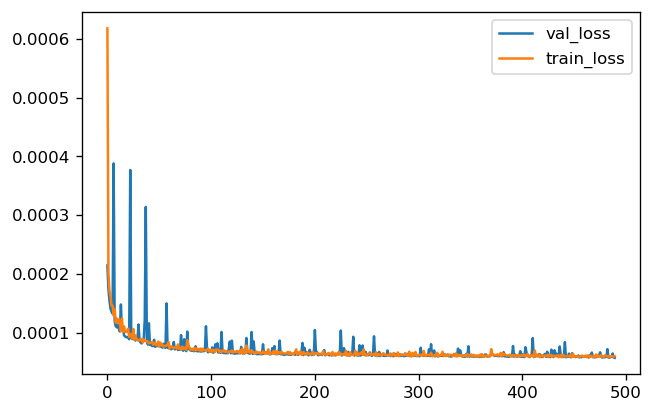

In [30]:
best_iteration = numpy.argmin(score.history['val_loss']) + 1

val_scores = score.history['val_loss'][0:best_iteration]
train_scores = score.history['loss'][0:best_iteration]

fig, ax = plt.subplots(dpi=120)

ax.plot(val_scores, label='val_loss')
ax.plot(train_scores, label='train_loss')

plt.legend(loc='upper right')
plt.show()

<h3>產生假圖</h3>

In [31]:
encoder = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer("latent").output)

encoded_imgs = encoder.predict(x_test)
print(encoded_imgs.shape)

encoded_imgs = encoded_imgs.reshape((len(encoded_imgs), max_dim[0]//2, max_dim[1]//2, 1))

(1122, 32, 32, 16)


In [32]:
decoded_imgs = autoencoder.predict(x_test)

In [33]:
x_test.shape, encoded_imgs.shape, decoded_imgs.shape

((1122, 256, 256, 3), (1122, 128, 128, 1), (1122, 256, 256, 3))

<h3>隨機顯示抽象圖與假圖</h3>

In [34]:
i = numpy.random.randint(0, x_test.shape[0], 1)[0]
i = 1021

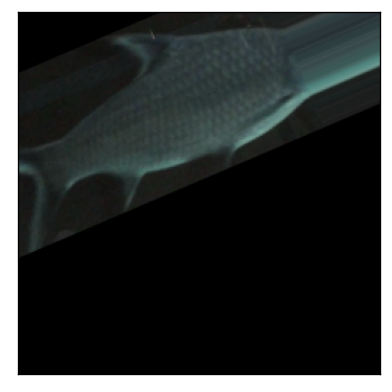

In [35]:
fig, ax = plt.subplots(dpi=120)

ax.imshow(x_test[i].reshape(max_dim))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


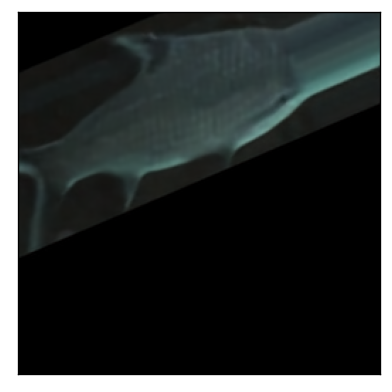

In [36]:
fig, ax = plt.subplots(dpi=120)

ax.imshow(decoded_imgs[i].reshape(max_dim), cmap=plt.cm.binary)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

plt.show()

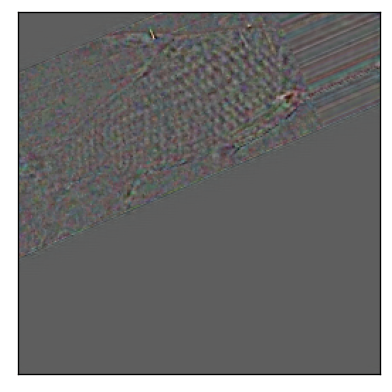

In [37]:
fig, ax = plt.subplots(dpi=120)

diff_image = x_test[i] - decoded_imgs[i]
diff_image_min = diff_image.min()
diff_image_max = diff_image.max()
diff_image_val = (diff_image - diff_image_min) / (diff_image_max - diff_image_min)

ax.imshow(diff_image_val.reshape(max_dim), cmap=plt.cm.binary)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

plt.show()

<h3>顯示原圖與假圖</h3>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


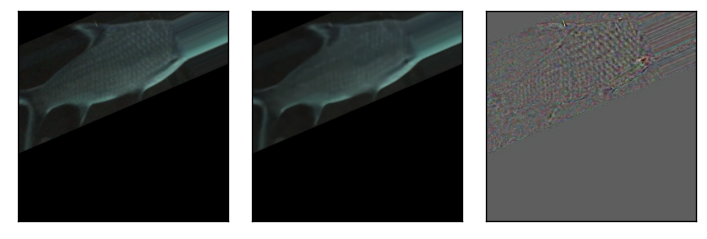

In [38]:
fig, (ax0, ax2, ax3) = plt.subplots(dpi=120, ncols=3)

ax0.imshow(x_test[i].reshape(max_dim), cmap=plt.cm.binary)
ax0.get_xaxis().set_visible(False)
ax0.get_yaxis().set_visible(False)

ax2.imshow(decoded_imgs[i].reshape(max_dim), cmap=plt.cm.binary)
ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)

diff_image = x_test[i] - decoded_imgs[i]
diff_image_min = diff_image.min()
diff_image_max = diff_image.max()
diff_image_val = (diff_image - diff_image_min) / (diff_image_max - diff_image_min)

ax3.imshow(diff_image_val.reshape(max_dim), cmap=plt.cm.binary)
ax3.get_xaxis().set_visible(False)
ax3.get_yaxis().set_visible(False)

plt.tight_layout()
plt.show()

In [39]:
def benchmark(my_diff_image):
    diff = 0.0
    
    for i in range(3):
        diff += numpy.sum(numpy.square(diff_image[i]))
        
    return diff**0.5

In [40]:
benchmark(diff_image)

0.4074508543305634

In [41]:
faint_image_files = glob('%s/F*.jpg' % 'images/objects/faint')

In [42]:
my_faint_images = []

for image_file in faint_image_files[:24]:
    _image_file = image_file.replace('\\', '/')

    _fish_image = read_image_file(_image_file, enhanced_flag)

    my_faint_images.append(numpy.reshape(_fish_image, max_dim))

my_faint_images = numpy.array(my_faint_images)

In [43]:
my_faint_images = my_faint_images.astype('float32') / 255.
my_faint_images = numpy.reshape(my_faint_images, (my_faint_images.shape[0],) + max_dim)

In [44]:
my_faint_images.shape

(24, 256, 256, 3)

<h3>產生假圖</h3>

In [45]:
encoding_dim = (32, 32, 16)

In [46]:
faint_encoder = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer("latent").output)

faint_encoded_imgs = faint_encoder.predict(my_faint_images)
faint_encoded_imgs = faint_encoded_imgs.reshape((len(faint_encoded_imgs), max_dim[0]//2, max_dim[1]//2, 1))

In [47]:
faint_decoded_imgs = autoencoder.predict(my_faint_images)

<h3>顯示原圖與假圖</h3>

In [48]:
def find_faint_file_pos(my_image_id=None):
    pos = -1
    
    if my_image_id is None:
        pos = numpy.random.randint(0, my_faint_images.shape[0], 1)[0]
    else:
        for j in range(len(faint_image_files)):
            image_file = faint_image_files[j]
            if my_image_id in image_file:
                pos = j
                break
            
    if pos == -1:
        pos = numpy.random.randint(0, my_faint_images.shape[0], 1)[0]
        
    return pos

In [49]:
i = find_faint_file_pos()
i = 7

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


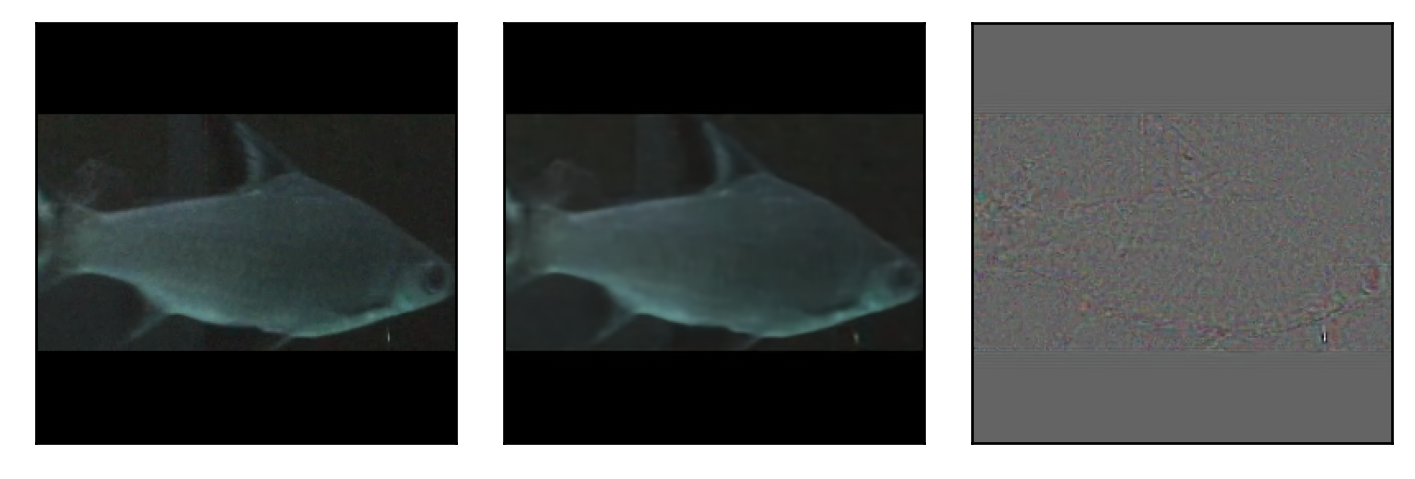

In [50]:
fig, (ax0, ax1, ax2) = plt.subplots(dpi=240, ncols=3)

ax0.imshow(my_faint_images[i].reshape(max_dim[0], max_dim[1], max_dim[2]))
ax0.get_xaxis().set_visible(False)
ax0.get_yaxis().set_visible(False)

ax1.imshow(faint_decoded_imgs[i].reshape(max_dim[0], max_dim[1], max_dim[2]))
ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)

faint_diff_image = my_faint_images[i] - faint_decoded_imgs[i]
faint_diff_image_min = faint_diff_image.min()
faint_diff_image_max = faint_diff_image.max()
faint_diff_image_val = (faint_diff_image - faint_diff_image_min) / (faint_diff_image_max - faint_diff_image_min)

ax2.imshow(faint_diff_image_val.reshape(max_dim), cmap=plt.cm.binary)
ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)

plt.tight_layout()
plt.show()

In [51]:
benchmark(faint_diff_image)

0.4074508543305634